In [1]:
# Importando dependências

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.tree import DecisionTreeRegressor  
import math
import os
! pip install patool
import patoolib

You should consider upgrading via the 'c:\users\felipe catapano\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
# Descomprimindo arquivo .rar e lendo o dataset
try:
    patoolib.extract_archive("vehicles.rar", outdir=os.getcwd())
    os.remove("vehicles.rar")
except:
    pass
Dataset = pd.read_csv('vehicles.csv')
Dataset = Dataset.iloc[28: , :]
Dataset.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500
32,7316343444,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,...,NaN,pickup,black,https://images.craigslist.org/00V0V_ftJbKrOgdi...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500
33,7316304717,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,...,NaN,pickup,silver,https://images.craigslist.org/00E0E_iKN07Sh7ou...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500
34,7316285779,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,35000,2019.0,toyota,tacoma,excellent,6 cylinders,...,NaN,truck,grey,https://images.craigslist.org/00101_dXoZTH7iVm...,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500
35,7316257769,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500
36,7316133914,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,...,NaN,other,red,https://images.craigslist.org/00U0U_kKYnS1LWh8...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500
37,7316130053,https://auburn.craigslist.org/cto/d/opelika-19...,auburn,https://auburn.craigslist.org,4500,1992.0,jeep,cherokee,excellent,6 cylinders,...,NaN,NaN,NaN,https://images.craigslist.org/01010_7EM2aot64G...,192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...,NaN,al,32.6454,-85.378300,2021-05-03T07:38:05-0500


# Quanto vale seu carro usado no Craigslist?

### A partir da análise de dados como quilometragem, ano do modelo, estado de conservação, tipo de combustível, entre outros, pretendemos prever o preço de revenda de um carro na plataforma Craigslist.   

In [3]:
# Remoção de outliers: Removeremos todas as linhas que tenham um preço com Z score(Número de desvios padrão
# de distância da média) maior ou igual a 3

z_scores = stats.zscore(Dataset.price)
abs_z = np.abs(z_scores)
Dataset['sigma'] = abs_z

Dataset = Dataset.loc[Dataset.sigma < 3,:]



# Análise exploratória -- Preços

Preço é a variável target do modelo. Assim, é de interesse analisar quais são os fatores fundamentais que influenciam em seu valor. Nesse sentido, através de gráficos de dispersão, histogramas e outras ferramentas estatísticas, determinaremos as features a serem consideradas.

clean         0.967701
rebuilt       0.017245
salvage       0.009240
lien          0.003397
missing       0.001944
parts only    0.000473
Name: title_status, dtype: float64


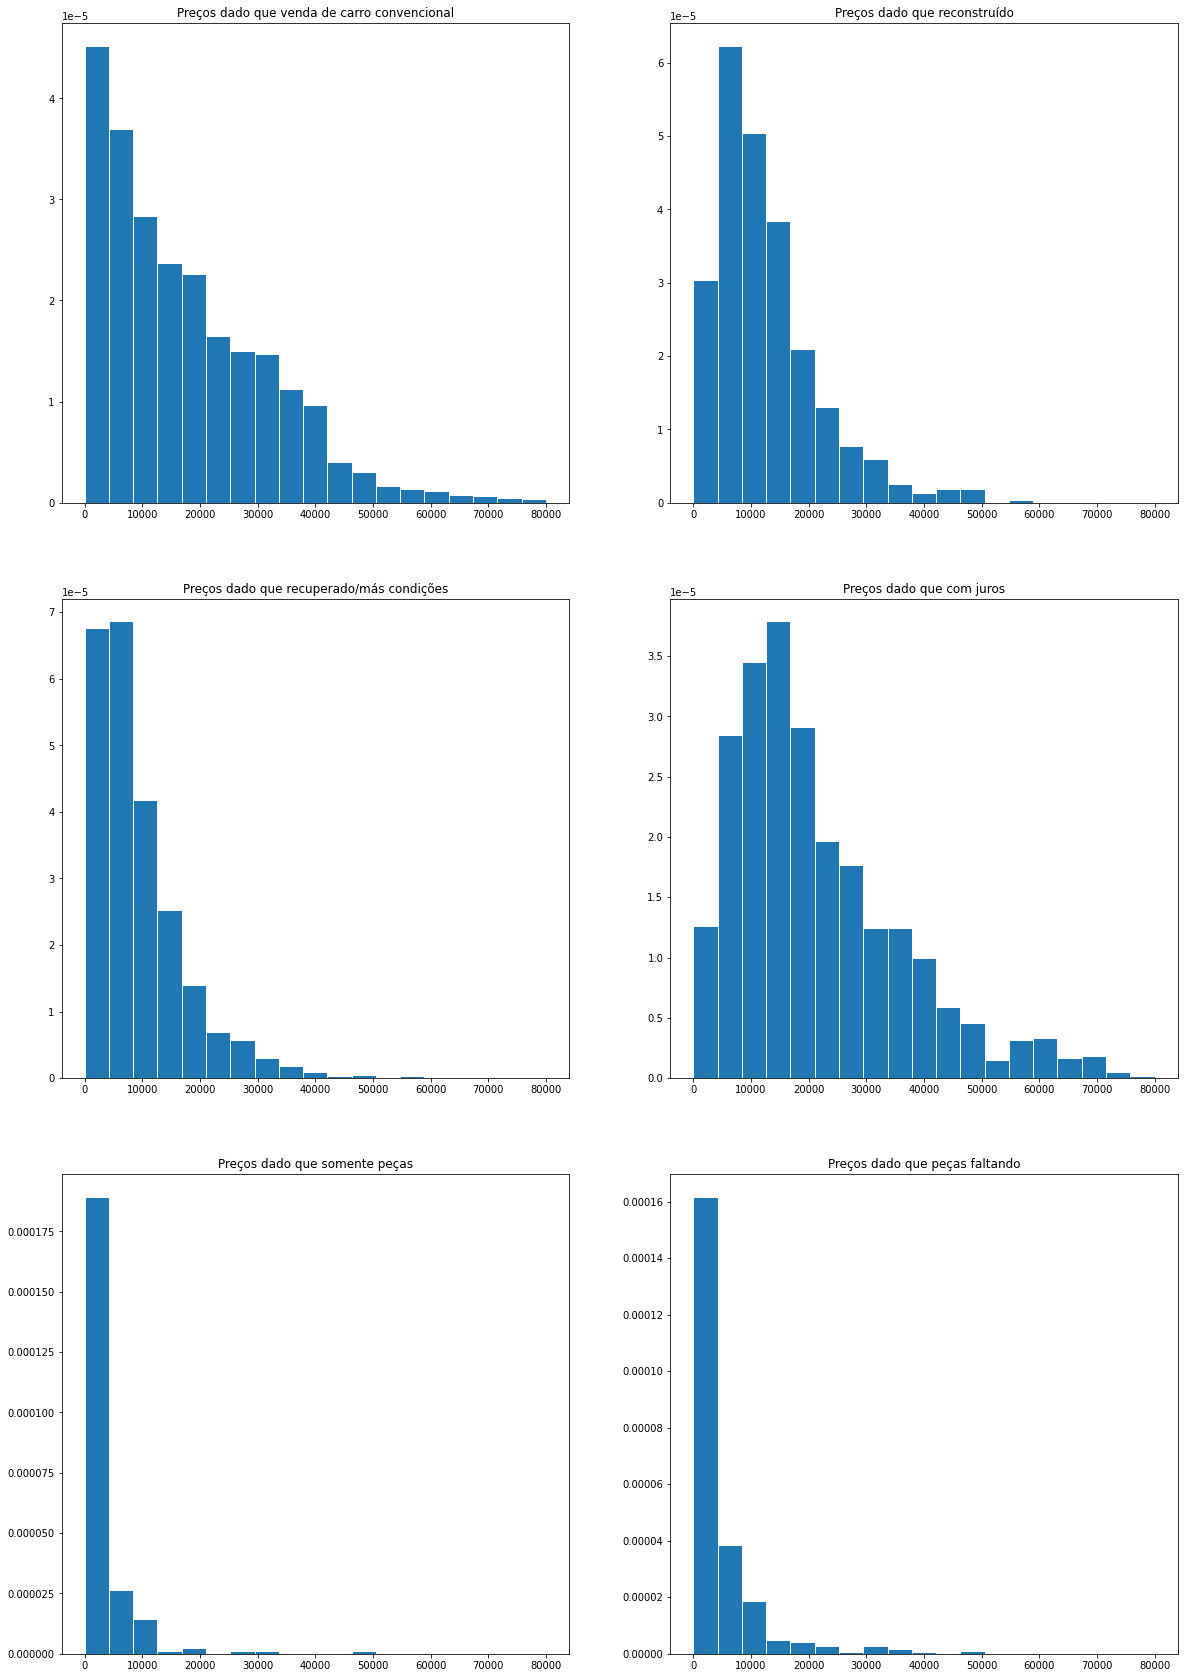

In [4]:
# Primeiramente, devemos decidir quais são as condições que o modelo assume. Imaginamos que venda de peças de carros
# ou de carros com peças faltando são casos significativamente diferentes do que a de um carro convencional. 

print(Dataset.title_status.value_counts(normalize=True))

# Para observar as diferenças:

bins = np.linspace(0,8e+4,20)

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dado que venda de carro convencional')
plt.hist(Dataset.loc[Dataset.title_status == 'clean']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dado que reconstruído')
plt.hist(Dataset.loc[Dataset.title_status == 'rebuilt']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dado que recuperado/más condições')
plt.hist(Dataset.loc[Dataset.title_status == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dado que com juros')
plt.hist(Dataset.loc[Dataset.title_status == 'lien']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dado que somente peças')
plt.hist(Dataset.loc[Dataset.title_status == 'parts only']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dado que peças faltando')
plt.hist(Dataset.loc[Dataset.title_status == 'missing']['price'],bins,edgecolor='white',density=True)
plt.show()



# Conclusão:

Percebe-se que os preços de peças, carros com peça faltando e em más condições destoam bastante do convencional por praticamente não serem vendidos à valores mais altos. Já no caso de carros "com juros" (car lien é a venda de um carro em parcelas, na qual o vendedor cobra juros por segurança, podendo recuperar o carro caso não seja pago), eles costumam ter valores maiores que carros convencionais. Para carros reconstruídos, eles não cotumam ser vendidos por preços muito baixos, mas tendem a ter preços menores que o convencional na maioria dos casos.

Como a maioria (cerca de 96%) da base de dados é composta por carros convencionais, e as categorias restantes possuem distribuições significativamente diferentes, escolhemos filtrar o modelo para venda de carros convencionais.

count    4.050960e+05
mean     1.805550e+04
std      6.964939e+04
min      0.000000e+00
25%      5.959000e+03
50%      1.399700e+04
75%      2.699000e+04
max      2.500300e+07
Name: price, dtype: float64


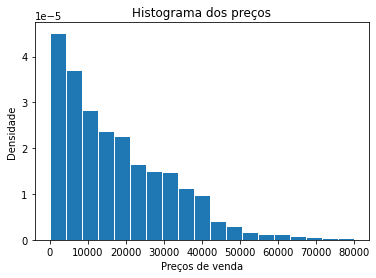

In [5]:
# Histograma de preços 

dados = Dataset.loc[Dataset.title_status == 'clean',:]

# Valores de interesse para basear as faixas
print(dados.price.describe())

bins = np.linspace(0,8e+4,20)

plt.hist(dados.price,bins=bins,edgecolor='white',density=True)
plt.title('Histograma dos preços')
plt.xlabel('Preços de venda')
plt.ylabel('Densidade')
plt.show()

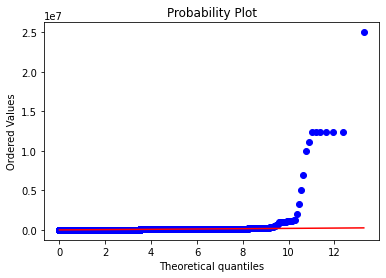

In [6]:
# O gráfico se assemelha com uma exponencial, para verificar temos que: 

stats.probplot(dados.price,dist='expon',plot=plt)
plt.show()

-0.03229251967047378


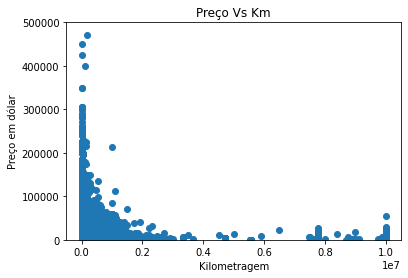

In [22]:
# Kilometragem e preço são relacionados?

print(dados.price.corr(dados.odometer))

plt.scatter(dados.odometer,dados.price)
plt.title('Preço Vs Km')
plt.ylabel('Preço em dólar')
plt.xlabel('Kilometragem')
plt.ylim(0, 0.5*(10**6))
plt.show()

# Correlação bem fraca e negativa

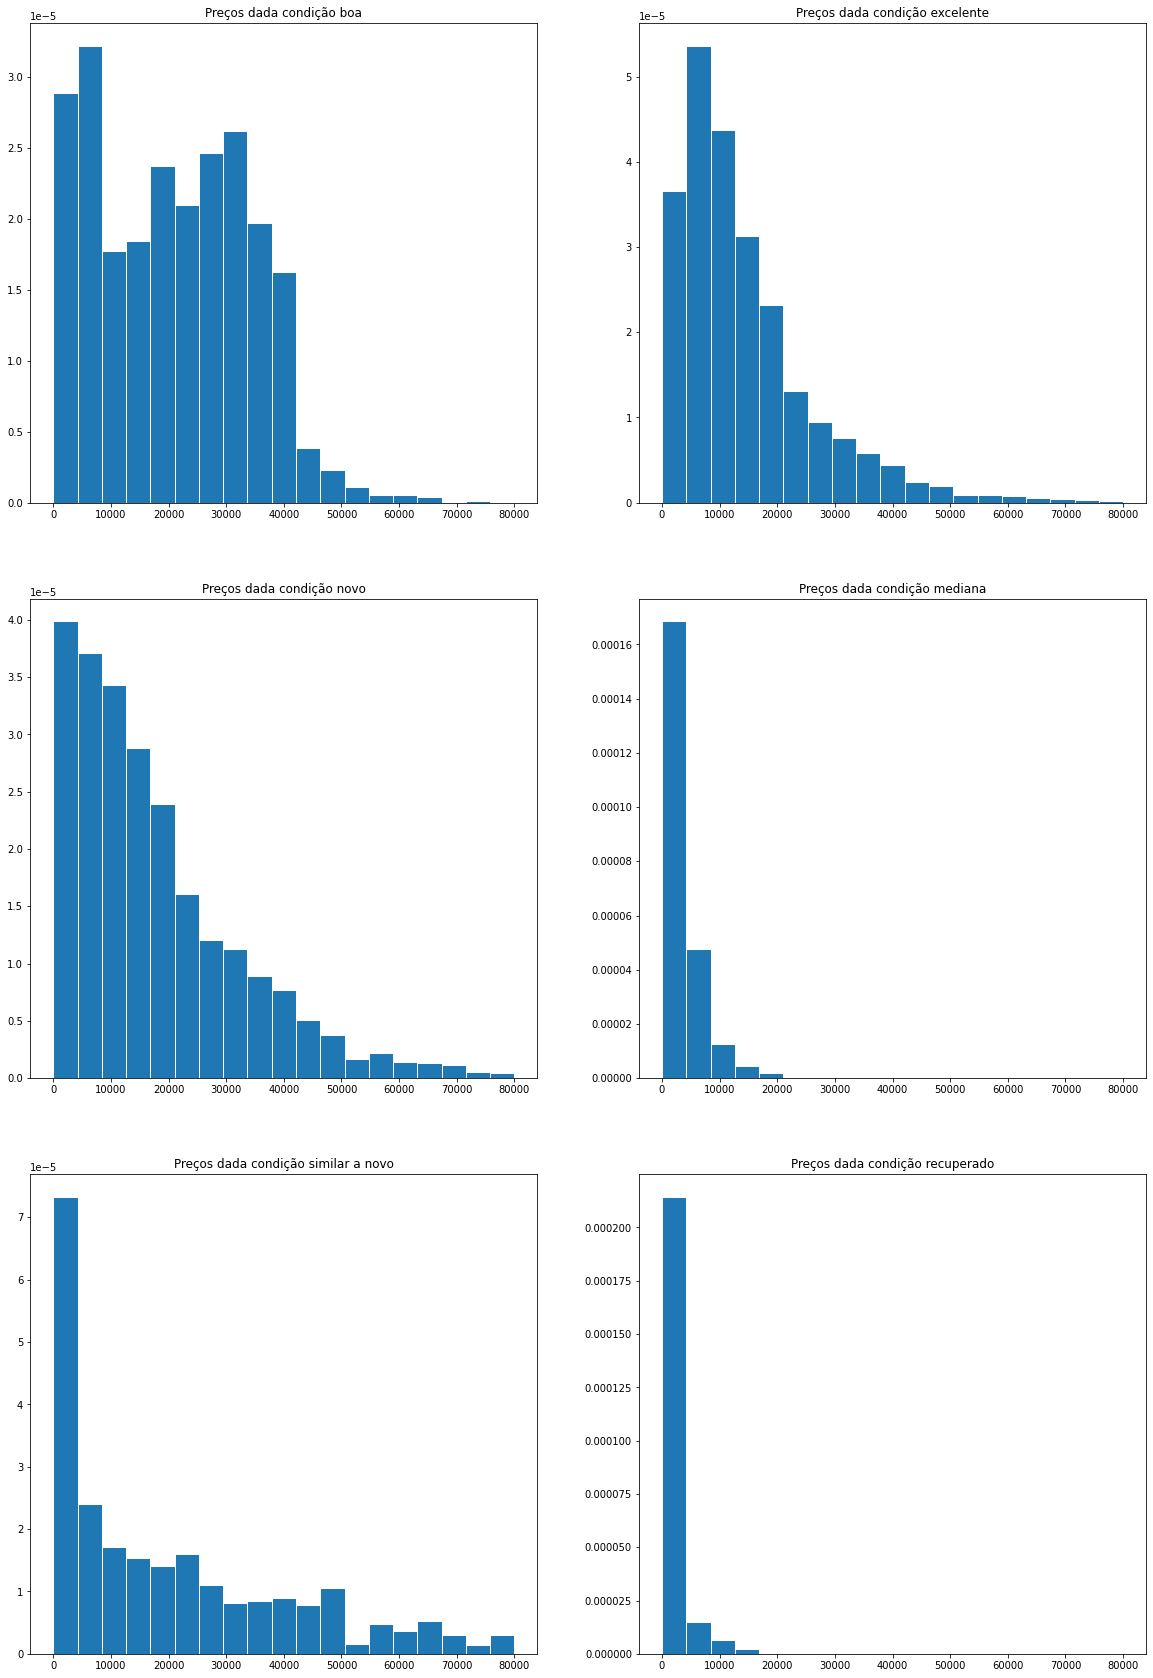

In [8]:
# Preço e condição se relacionam?

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dada condição boa')
plt.hist(dados.loc[dados.condition == 'good']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dada condição excelente')
plt.hist(dados.loc[dados.condition == 'excellent']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dada condição novo')
plt.hist(dados.loc[dados.condition == 'like new']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dada condição mediana')
plt.hist(dados.loc[dados.condition == 'fair']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dada condição similar a novo')
plt.hist(dados.loc[dados.condition == 'new']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dada condição recuperado')
plt.hist(dados.loc[dados.condition == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.show()


automatic    0.788507
other        0.153129
manual       0.058364
Name: transmission, dtype: float64


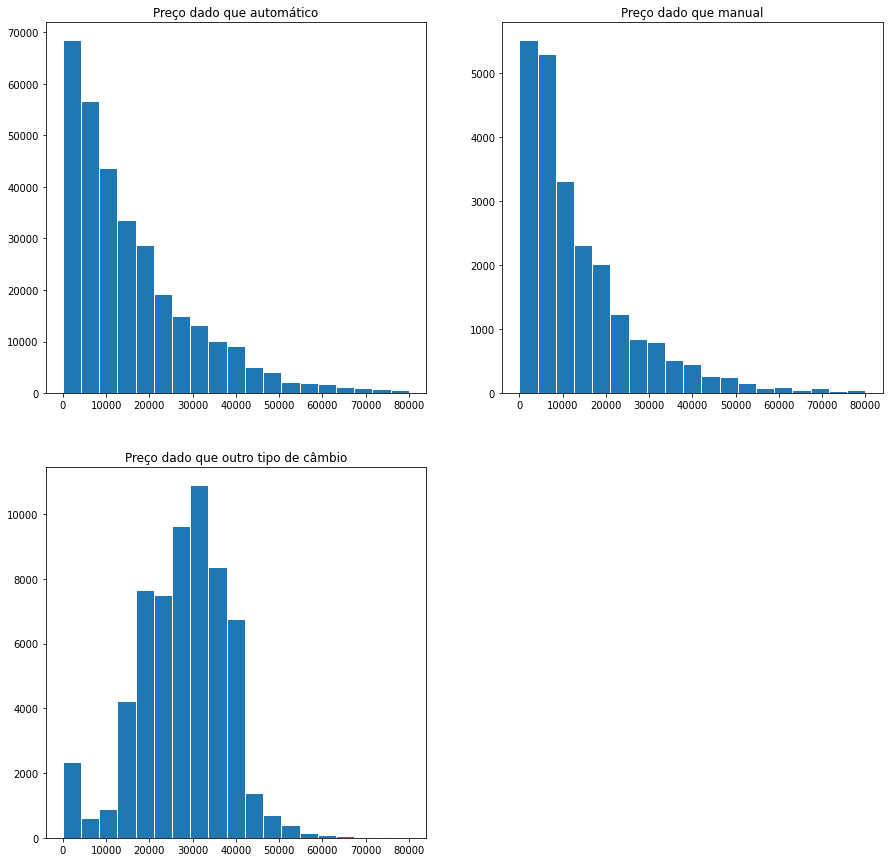

In [9]:
# Preço e tipo de câmbio se relacionam?

print(dados.transmission.value_counts(normalize=True))

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hist(dados.loc[dados.transmission=='automatic']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que automático')
plt.subplot(222)
plt.hist(dados.loc[dados.transmission=='manual']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que manual')
plt.subplot(223)
plt.hist(dados.loc[dados.transmission=='other']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que outro tipo de câmbio')
plt.show()

# Percebe-se que carros automáticos e manuais tem uma distribuição relativamente parecida, diferentemente
# dos outros tipos, que destoam do padrão de preços.



0.05957994931034666


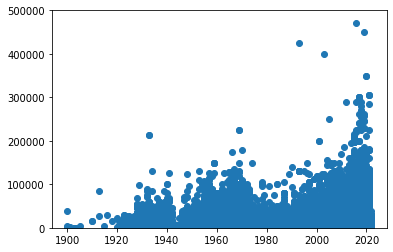

In [10]:
# Preço e ano de fabricação se relacionam?

print(dados.price.corr(dados.year))
plt.scatter(dados.year,dados.price)
plt.ylim(0, 0.5*(10**6))
plt.show()

# Associação fraca e positiva

In [17]:
dum = pd.get_dummies(Dataset, drop_first=False, columns=['year', 'title_status', 'condition', 'transmission', 'cylinders', 'fuel', 'type', 'paint_color', 'manufacturer', 'drive', 'size'])

X = dum.iloc[:, 25:]

results = sm.OLS(dum.price, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.078
Model:                            OLS   Adj. R-squared (uncentered):              0.077
Method:                 Least Squares   F-statistic:                              173.1
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                        0.00
Time:                        18:18:24   Log-Likelihood:                     -5.3809e+06
No. Observations:              426832   AIC:                                  1.076e+07
Df Residuals:                  426624   BIC:                                  1.076e+07
Df Model:                         208                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
year_1915.0                  -1.044e+04   7.23e+04     -0.145      0.885   -1.52e+05    1.31e+05
year_1916.0                   -681.4044   5.11e+04     -0.013      0.989   -1.01e+05    9.95e+04
year_1918.0                  -2833.4873   7.23e+04     -0.039      0.969   -1.44e+05    1.39e+05
year_1920.0                  -9373.0068   5.11e+04     -0.183      0.855    -1.1e+05    9.08e+04
year_1921.0                  -7644.5519   5.11e+04     -0.150      0.881   -1.08e+05    9.25e+04
year_1922.0                  -5483.2772   4.17e+04     -0.131      0.896   -8.73e+04    7.63e+04
year_1923.0                  -4847.3952   1.22e+04     -0.399      0.690   -2.87e+04     1.9e+04
year_1924.0                  -7155.9526   2.42e+04     -0.296      0.767   -5.45e+04    4.02e+04
year_1925.0                  -9358.2878   2.56e+04     -0.366      0.715   -5.95e+04    4.08e+04
year_1926.0                  -1.047e+04   1.81e+04     -0.577      0.564    -4.6e+04    2.51e+04
year_1927.0                  -6885.6173    1.2e+04     -0.574      0.566   -3.04e+04    1.66e+04
year_1928.0                   5843.0373   1.18e+04      0.494      0.621   -1.73e+04     2.9e+04
year_1929.0                  -1071.1335   9706.379     -0.110      0.912   -2.01e+04     1.8e+04
year_1930.0                   2557.4009   8910.783      0.287      0.774   -1.49e+04       2e+04
year_1931.0                    836.4741   9620.869      0.087      0.931    -1.8e+04    1.97e+04
year_1932.0                   1.017e+04   9706.484      1.048      0.295   -8850.710    2.92e+04
year_1933.0                   2.851e+04   1.45e+04      1.961      0.050      19.367     5.7e+04
year_1934.0                    1.11e+04    1.1e+04      1.007      0.314   -1.05e+04    3.27e+04
year_1935.0                   -350.0844   1.52e+04     -0.023      0.982   -3.01e+04    2.94e+04
year_1936.0                   1139.0912   1.11e+04      0.102      0.918   -2.07e+04     2.3e+04
year_1937.0                   7079.3085   8780.971      0.806      0.420   -1.01e+04    2.43e+04
year_1938.0                  -1997.5118   1.18e+04     -0.169      0.866   -2.52e+04    2.12e+04
year_1939.0                    536.1020   9965.226      0.054      0.957    -1.9e+04    2.01e+04
year_1940.0                   5664.4642   8178.229      0.693      0.489   -1.04e+04    2.17e+04
year_1941.0                  -3611.3607   8967.132     -0.403      0.687   -2.12e+04     1.4e+04
year_1942.0                  -1115.8620   1.87e+04     -0.060      0.952   -3.78e+04    3.56e+04
year_1943.0                  -6681.4676   7.23e+04     -0.092      0.926   -1.48e+05    1.35e+05
year_1944.0                  -2.183e+04   4.18e+04     -0.523      0.601  

In [15]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X, dum.price)
score = regressor.score(X, dum.price)
score

0.8988660253293067

In [11]:
Dataset['odometer_log'] = np.round(np.log10(Dataset['odometer']))
Dataset['odometer_log'].value_counts()

C:\Users\Felipe Catapano\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


 5.0    330209
 4.0     74237
 3.0      6520
 2.0      2865
 0.0      2457
 6.0      2431
-inf      1964
 1.0      1573
 7.0       203
Name: odometer_log, dtype: int64